<a href="https://colab.research.google.com/github/AntonioWh1te/The-Journey/blob/main/Phase_2_1_Financial_Modeling_Prep_(FMP)_Introduction.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Step 0: Understanding the Task
* Goal: Fetch the closing prices of AAPL, NVDA, and TSLA over the past year, then plot them.

* Extensions
  1. Changing data frequency to daily or hourly
  2. Exploring different plot types (line, bar, candlestick).
  3. Possibly creating animations.

**Key Idea:** We'll use FMP's historical endpoints to retrieve data, parse it into Pandas, and visualize it with Matplotlib.

# Step 1: Explore the FMP API (Application Programming Interface)



Enter your FMP API Key: ··········


<ipython-input-1-5b303c767f93>:113: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  df_resampled = df.resample(freq).last()
<ipython-input-1-5b303c767f93>:113: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  df_resampled = df.resample(freq).last()
<ipython-input-1-5b303c767f93>:113: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  df_resampled = df.resample(freq).last()


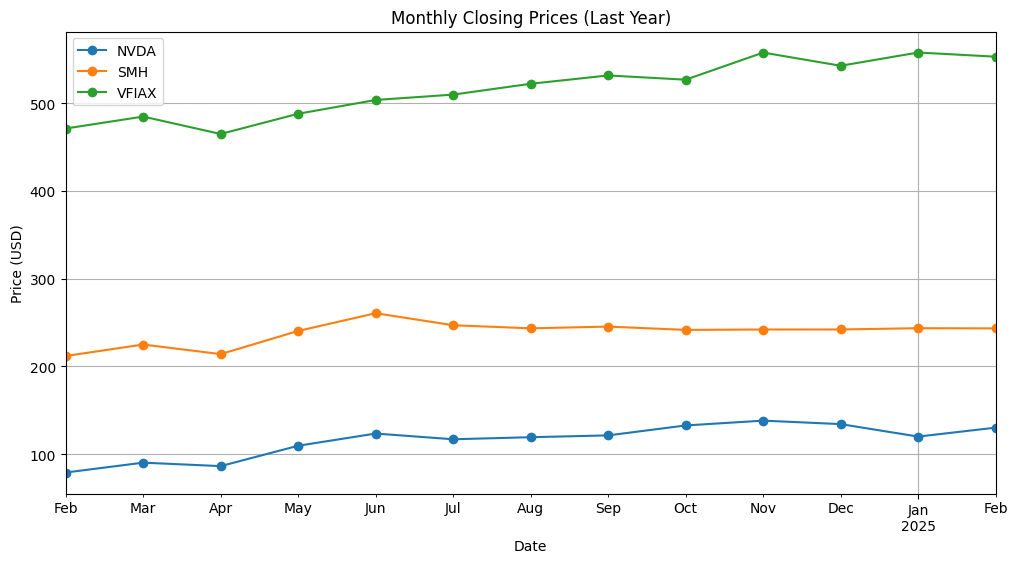

In [1]:
##############################################
# IMPORTS & BASE URL
##############################################

# We will use requests to call the Financial Modeling Prep API,
# pandas to structure and manipulate our data,
# matplotlib to visualize it.

import getpass
import requests
import pandas as pd
import matplotlib.pyplot as plt

# The base URL for the Financial Modeling Prep API:
BASE_url = "https://financialmodelingprep.com/api/v3"

##############################################
# SECURELY ASK FOR API KEY
##############################################

# Securely asks for my API key and saves it as api_key to input simply in the program for future use.
api_key = getpass.getpass("Enter your FMP API Key: ")

##############################################
# FETCH_STOCK_DATA FUNCTION
##############################################
"""
We will build one function that can fetch either daily or intraday data.
We will deal with monthly/quarterly/yearly by resampling in Pandas later.
Depending on the data frequency (daily or intraday), we append the correct endpoint:
(historical-price-full) or (historical-chart/<interval>)
"""

def fetch_stock_data(ticker, api_key, frequency='daily'):
    """
    Fetch historical stock data from Financial Modeling Prep.

    :param ticker: Stock symbol (e.g., 'AAPL').
    :param api_key: Your FMP API key.
    :param frequency: 'daily' for daily data, or '1hour', '15min', etc. for intraday data.
    :return: A Pandas DataFrame with a DatetimeIndex and a 'close' column.
    """

    # 1) Build endpoint path depending on frequency
    if frequency == 'daily':
        endpoint = f"historical-price-full/{ticker}"
    else:
        endpoint = f"historical-chart/{frequency}/{ticker}"
    # The '==' means 'is equal to.' So the function checks the value of frequency
    # and if it's daily, it does one thing, and if it's something else it does another.

    # 2) Construct the full URL by combining BASE_url, endpoint, and API key.
    #    The f goes before the string (f-string) to allow me to embed variables
    #    and expressions directly into the string by enclosing them in curly brackets {}.
    #    In a URL, the / is used to separate different parts of the path.
    #    The ? indicates the start of the query string. Everything after ? are parameters.
    url = f"{BASE_url}/{endpoint}?apikey={api_key}"

    # 3) Make the request
    #    'requests.get(url)' is like calling a store and asking for a toy. The store sends back a package.
    #    We store that package in 'response.' response.json() opens the package and translates JSON into a Python list/dict.
    response = requests.get(url)
    data_json = response.json()

    # 4) For daily data, the JSON has a "historical" key.
    if frequency == 'daily':
        if "historical" not in data_json:
            raise ValueError(f"No 'historical' field found in response. Response was: {data_json}")
        records = data_json["historical"]
    else:
        # For intraday data, the JSON should be a list of records.
        if not isinstance(data_json, list):
            raise ValueError(f"Expected a list for intraday data, got {type(data_json)}. Response: {data_json}")
        records = data_json

    # 5) Convert to DataFrame
    df = pd.DataFrame(records)

    # 6) Ensure we have a 'date' column to parse
    if 'date' not in df.columns:
        raise ValueError("No 'date' column found in the data.")
    df['date'] = pd.to_datetime(df['date'])
    df.set_index('date', inplace=True)

    # 7) Keep only the 'close' column for simplicity
    if 'close' not in df.columns:
        raise ValueError("No 'close' column found in the data.")
    df = df[['close']]

    # 8) Sort by date ascending (FMP sometimes returns descending order)
    df.sort_index(inplace=True)

    return df

##############################################
# RESAMPLE_DATA FUNCTION
##############################################
"""
This function will resample a DataFrame to monthly, quarterly, yearly, etc.
We can also choose how to aggregate the data: 'last', 'mean', 'first', etc.
"""

def resample_data(df, freq='M', agg='last'):
    """
    Resample a daily DataFrame to monthly, quarterly, or yearly.

    :param df: Pandas DataFrame with a DatetimeIndex.
    :param freq: 'M' (monthly), 'Q' (quarterly), 'Y' (yearly), 'W' (weekly), etc.
    :param agg: 'last', 'mean', 'first', or any valid Pandas aggregation.
    :return: Resampled DataFrame.
    """
    if agg == 'last':
        df_resampled = df.resample(freq).last()
    elif agg == 'mean':
        df_resampled = df.resample(freq).mean()
    elif agg == 'first':
        df_resampled = df.resample(freq).first()
    else:
        # fallback to any valid Pandas aggregation
        df_resampled = df.resample(freq).agg(agg)
    return df_resampled

##############################################
# MAIN SCRIPT
##############################################
"""
Putting it all together:
1) Fetch daily data for tickers
2) Filter to last year
3) Resample to monthly (last day of each month)
4) Rename 'close' column to the ticker name
5) Combine into one DataFrame
6) Plot
"""

tickers = ["VOO", "SMH", "AAPL"]
combined_df = pd.DataFrame()

for t in tickers:
    # 1) Fetch daily data
    df_daily = fetch_stock_data(t, api_key, frequency='daily')

    # 2) Filter to last year
    one_year_ago = pd.Timestamp.today() - pd.Timedelta(days=365)
    df_daily = df_daily.loc[df_daily.index >= one_year_ago]

    # 3) Resample to monthly (last day of each month)
    df_monthly = resample_data(df_daily, freq='M', agg='last')

    # 4) Rename 'close' column to ticker name
    df_monthly.rename(columns={'close': t}, inplace=True)

    # 5) Combine into one DataFrame
    if combined_df.empty:
        combined_df = df_monthly
    else:
        combined_df = combined_df.join(df_monthly, how='outer')

# 6) Plot
combined_df.plot(figsize=(12, 6), marker='o')  # Using marker='o' for data points
plt.title("Monthly Closing Prices (Last Year)")
plt.xlabel("Date")
plt.ylabel("Price (USD)")
plt.grid(True)  # Turns on the grid lines on the plot
plt.show()
